In [106]:
import pandas as pd
d = pd.read_csv("d_data.csv", parse_dates=["date"]).set_index("date")
d.head()
d.columns

Index(['gdp_def', 'gdp', 'cons', 'inv', 'gov', 'inflation', 'long_rate',
       'short_rate', 't_total', 't_income', 't_corp', 't_cons', 't_other',
       'dispo_income', 'dispo_corp'],
      dtype='object')

In [107]:
import numpy as np
d.corr()

,gdp_def,gdp,cons,inv,gov,inflation,long_rate,short_rate,t_total,t_income,t_corp,t_cons,t_other,dispo_income,dispo_corp
gdp_def,1.000000,0.109413,0.060407,0.451669,0.194342,0.086618,0.291409,0.283244,0.139344,0.384214,0.227742,-0.096237,0.259820,0.070410,0.073849
gdp,0.109413,1.000000,0.989646,0.828491,0.967214,-0.196351,-0.798260,-0.760693,0.761235,0.350725,0.060521,0.892823,0.045500,0.996639,0.999556
cons,0.060407,0.989646,1.000000,0.776576,0.952144,-0.286883,-0.715003,-0.815791,0.678601,0.253793,-0.030399,0.857270,0.010872,0.996264,0.992361
inv,0.451669,0.828491,0.776576,1.000000,0.775734,0.022921,-0.451727,-0.114732,0.818623,0.671933,0.438035,0.660826,0.260964,0.797834,0.812758
gov,0.194342,0.967214,0.952144,0.775734,1.000000,-0.176162,-0.797670,-0.806351,0.740680,0.324213,-0.020966,0.912208,0.000840,0.962784,0.968586
inflation,0.086618,-0.196351,-0.286883,0.022921,-0.176162,1.000000,-0.528659,0.416564,0.283945,0.488697,0.401156,0.010653,0.137163,-0.304920,-0.258710
long_rate,0.291409,-0.798260,-0.715003,-0.451727,-0.797670,-0.528659,1.000000,0.500427,-0.712204,-0.204070,0.041054,-0.896928,0.262436,-0.734625,-0.780522
short_rate,0.283244,-0.760693,-0.815791,-0.114732,-0.806351,0.416564,0.500427,1.000000,-0.118491,0.491621,0.514483,-0.655862,0.474180,-0.808411,-0.779210
t_total,0.139344,0.761235,0.678601,0.818623,0.740680,0.283945,-0.712204,-0.118491,1.000000,0.783466,0.546531,0.819375,0.319597,0.705558,0.745959
t_income,0.384214,0.350725,0.253793,0.671933,0.324213,0.488697,-0.204070,0.491621,0.783466,1.000000,0.634211,0.365240,0.450081,0.284305,0.332272


In [108]:
import pandas as pd
import numpy as np
# 2SLS (操作変数法) のためのライブラリ
from linearmodels.iv import IV2SLS

In [109]:
import pandas as pd
import numpy as np
from linearmodels.iv import IV2SLS
import statsmodels.api as sm # 定数項追加用

# 1. データの準備とラグ変数の作成
# d = pd.read_csv(...) 等で読み込み済みと仮定
d['cons_lag'] = d['cons'].shift(1)
d['inv_lag'] = d['inv'].shift(1)
d['gov_lag'] = d['gov'].shift(1)

# 定数項（Intercept）をデータセットに追加
d = sm.add_constant(d) 
d = d.dropna() # ラグ作成による欠損値の削除

# 操作変数のリスト（システム全体の外生変数）
# const, t_total, long_rate, cons_lag, inv_lag, gov_lag
iv_list = ['const', 't_total', 'long_rate', 'cons_lag', 'inv_lag', 'gov_lag']

# --- (1) 消費関数の推定 ---
# C = c0 + c1 * dispo_income + c2 * C_t-1
res_cons = IV2SLS(
    dependent=d['cons'],
    exog=d[['const', 'cons_lag']], 
    endog=d[['dispo_income']], 
    instruments=d[[c for c in iv_list if c not in ['const', 'cons_lag']]]
).fit()

# --- (2) 投資関数の推定 ---
# I = i0 + i1 * long_rate + i2 * I_t-1
# ※ ここでは long_rate を外生と仮定
res_inv = IV2SLS(
    dependent=d['inv'],
    exog=d[['const', 'long_rate', 'inv_lag']],
    endog=None,
    instruments=None
).fit()

# --- (3) 政府支出関数の推定 ---
# G = g0 + g1 * T + g2 * G_t-1
# ※ T (t_total) は外生変数として扱うのが一般的です
res_gov = IV2SLS(
    dependent=d['gov'],
    exog=d[['const', 't_total', 'gov_lag']],
    endog=None,
    instruments=None
).fit()

# 結果の表示
print("=== Consumption Function ===")
print(res_cons.summary)
print("\n=== Investment Function ===")
print(res_inv.summary)
print("\n=== Government Expenditure Function ===")
print(res_gov.summary)

=== Consumption Function ===
                          IV-2SLS Estimation Summary                          
Dep. Variable:                   cons   R-squared:                      0.9871
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9870
No. Observations:                 153   F-statistic:                 1.363e+04
Date:                Thu, Dec 18 2025   P-value (F-stat)                0.0000
Time:                        09:34:40   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
const            8509.0     2210.8     3.8487     0.0001      4175.8   1.284e+04
cons_lag       

In [110]:
import pandas as pd
from linearmodels.iv import IV2SLS

# --- A. 物価関数 (GDPデフレーター) の推定 ---
# GDPが増えると物価が上がるメカニズムを推定
# 操作変数には、政府支出のラグや税収などを使用
d['gdp_def_lag'] = d['gdp_def'].shift(1)

res_def = IV2SLS(
    dependent=d['gdp_def'],
    exog=d[['const', 'gdp_def_lag']], 
    endog=d[['gdp']], 
    instruments=d[['t_total', 'long_rate', 'inv_lag', 'gov_lag']]
).fit()

# --- B. 消費関数 (実質) の推定 ---
res_cons = IV2SLS(
    dependent=d['cons'],
    exog=d[['const', 'cons_lag']], 
    endog=d[['dispo_income']], 
    instruments=d[['t_total', 'long_rate', 'inv_lag', 'gov_lag']]
).fit()

# --- C. 投資関数 (実質) の推定 ---
res_inv = IV2SLS(
    dependent=d['inv'],
    exog=d[['const', 'inv_lag']], 
    endog=d[['long_rate']], # 金利が投資を決める
    instruments=d[['t_total', 'gov_lag']] # 金利に対する操作変数
).fit()

print("=== GDPデフレーター関数の推定結果 ===")
print(res_def.summary)
print("\n=== 消費関数の推定結果 ===")
print(res_cons.summary)

# 長期金利を短期金利と景気で説明する式
d['long_rate_lag'] = d['long_rate'].shift(1)
rate = d[['long_rate','const', 'short_rate', 'long_rate_lag', 'gdp']].dropna()
res_rate = sm.OLS(rate['long_rate'], rate[['const', 'short_rate', 'long_rate_lag', 'gdp']]).fit()
print(res_rate.summary())

=== GDPデフレーター関数の推定結果 ===
                          IV-2SLS Estimation Summary                          
Dep. Variable:                gdp_def   R-squared:                      0.9910
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9909
No. Observations:                 152   F-statistic:                 2.135e+04
Date:                Thu, Dec 18 2025   P-value (F-stat)                0.0000
Time:                        09:34:40   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const          -0.6687     1.3007    -0.5141     0.6072     -3.2180      1.8806
gdp_def_lag     1.0031 

/home/shouyanyonga/good_env/lib/python3.11/site-packages/linearmodels/iv/model.py:557: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


In [111]:
d["long_rate"].corr(d["short_rate"])

np.float64(0.5049143392284161)

In [112]:
# インデックスに関わらず、最後の一行を取得
latest_data = d.iloc[-1]

print("--- Latest Row Data ---")
print(latest_data)

# 特定の変数の値だけ欲しい場合
d

--- Latest Row Data ---
const                 1.000000
gdp_def             109.900000
gdp              588234.400000
cons             304995.100000
inv              127737.000000
gov              149262.800000
inflation             2.999063
long_rate            -1.975364
short_rate            0.227000
t_total           69797.203898
t_income          19676.454314
t_corp            16616.336394
t_cons            23125.904538
t_other           10378.508652
dispo_income     518437.196102
dispo_corp       571618.063606
cons_lag         305069.600000
inv_lag          127838.600000
gov_lag          149358.600000
gdp_def_lag         109.000000
long_rate_lag        -1.679003
Name: 2024-10-01 00:00:00, dtype: float64


,const,gdp_def,gdp,cons,inv,gov,inflation,long_rate,short_rate,t_total,...,t_corp,t_cons,t_other,dispo_income,dispo_corp,cons_lag,inv_lag,gov_lag,gdp_def_lag,long_rate_lag
date,,,,,,,,,,,,,,,,,,,,,
1986-10-01,1.0,101.420504,364287.135680,197129.079031,90736.612408,89027.823060,1.473477,3.907977,4.252100,41856.365495,...,13084.711973,0.000000,11953.164400,322430.770184,351202.423707,196500.833752,88959.927517,86187.862318,NaN,NaN
1987-01-01,1.0,101.224143,365533.316387,200125.168942,91674.478196,87853.263417,0.389484,4.621228,4.199800,44942.538173,...,15183.960873,0.000000,13012.793143,320590.778213,350349.355513,197129.079031,90736.612408,89027.823060,101.420504,3.907977
1987-04-01,1.0,101.027782,371880.088125,201338.240861,95475.968318,88926.811328,-0.387222,4.415062,3.439167,45722.877525,...,15447.600682,0.000000,13238.734868,326157.210600,356432.487442,200125.168942,91674.478196,87853.263417,101.224143,4.621228
1987-07-01,1.0,101.322323,378661.859232,204315.679103,99106.001354,90840.267811,-0.386100,5.846072,3.374767,46556.700307,...,15729.310016,0.000000,13480.162340,332105.158925,362932.549216,201338.240861,95475.968318,88926.811328,101.027782,4.415062
1987-10-01,1.0,101.224143,388361.222863,208189.518583,102290.827933,93220.605290,-0.193611,5.698876,3.661433,47749.242822,...,16132.213805,0.000000,13825.454566,340611.980041,372229.009058,204315.679103,99106.001354,90840.267811,101.322323,5.846072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,1.0,106.700000,584165.100000,304350.200000,128677.200000,146220.200000,4.916421,-4.144018,-0.015667,68353.349889,...,15041.395709,21838.102370,10559.895241,515811.750111,569123.704291,304427.200000,126125.800000,146407.300000,106.200000,-5.487245
2024-01-01,1.0,106.500000,581006.300000,303295.800000,125871.600000,146267.000000,3.398058,-2.686472,0.000667,68939.550606,...,16412.158364,22997.057059,10095.660981,512066.749394,564594.141636,304350.200000,128677.200000,146220.200000,106.700000,-4.144018
2024-04-01,1.0,108.500000,582394.900000,303446.100000,127030.400000,149166.500000,3.629417,-2.689014,0.077000,69104.315532,...,16451.383280,23008.453385,10163.355964,513290.584468,565943.516720,303295.800000,125871.600000,146267.000000,106.500000,-2.686472


## モデル式
Ct = 9398.9 + 0.0216 * (Y-T) + 0.9331 * Ct-1


It = 5875.2 + 24.170 * r + 0.9508 * It-1


Gt = 2115.1 + 0.0247 * T + 0.9761 * Gt-1


Def_t = -0.7073 + 1.0033 * Def_{t-1} + 0.00000081 * GDP_t


AttributeError: 'Axes' object has no attribute 'get_legend_han0dles_labels'

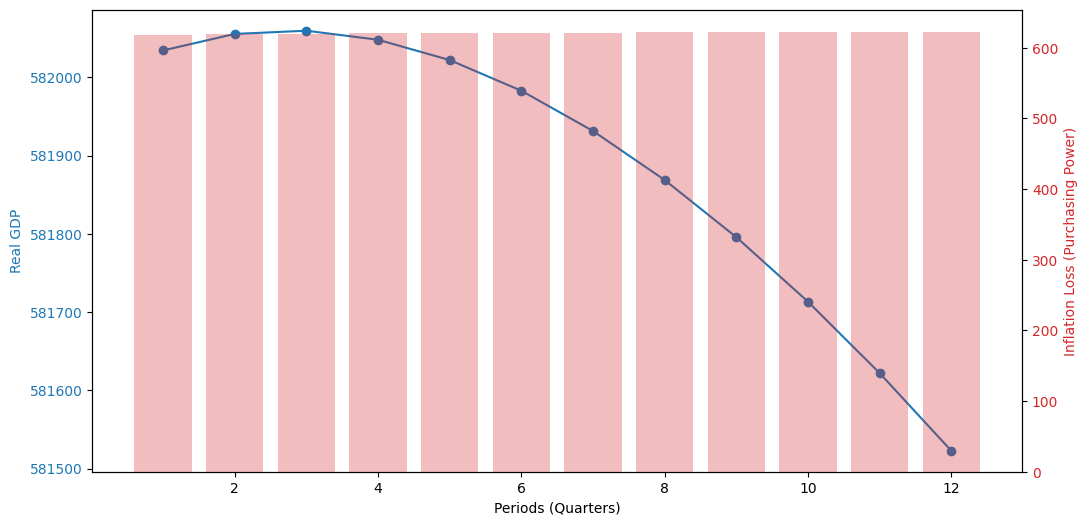

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def advanced_macro_sim(t_pct=-10, short_rate_val=0.227, periods=12):
    # --- 推定パラメータ ---
    c0, c1, c2 = 9398.9, 0.0216, 0.9331        # 消費
    i0, i1, i2 = 5875.2, 24.170, 0.9508        # 投資 (i1は金利の影響)
    p0, p1, p2 = -0.7073, 1.0033, 8.149e-07     # 物価 (GDPデフレーター)
    g0, g1, g2 = 2115.1, 0.0247, 0.9761        # 政府支出
    r0, r1 = 1.2057, 0.4924                    # 金利波及 (Short -> Long)

    # --- 初期値（最新データ反映） ---
    def_lag = 109.9  # 直近デフレーター
    c_lag, i_lag, g_lag = 304995.1, 127737.0, 149262.8
    long_rate_lag = -1.679003  # 長期金利のラグ
    
    # 名目所得（実質GDP * デフレーター/100） ※名目成長なし設定
    y_real_init = c_lag + i_lag + g_lag
    nominal_inc = y_real_init * (def_lag / 100) 

    # 政策変数
    T_base = 69797.2
    T = T_base * (1 + t_pct / 100)
    short_rate = short_rate_val  # 指定された最新短期金利

    results = []
    for p in range(1, periods + 1):
        y_guess = y_real_init
        
        # 収束ループ（GDP、物価、金利の同時決定）
        for _ in range(50):
            # 1. 長期金利の決定 (短期金利からの波及)
            # 推定結果に基づき、短期金利から長期金利が決まるとする
            long_rate = r0 + r1 * short_rate
            
            # 2. 物価の決定
            def_now = p0 + p1 * def_lag + p2 * y_guess
            
            # 3. 実質可処分所得 (名目所得を最新の物価で割る)
            # ※「名目所得の微増」を削除しているため、物価高がダイレクトに実質所得を削る
            real_dispo = (nominal_inc - T) / (def_now / 100)
            
            # 4. 各需要項目の計算
            ct = c0 + c1 * real_dispo + c2 * c_lag
            it = i0 + i1 * long_rate + i2 * i_lag
            gt = g0 + g1 * T + g2 * g_lag
            
            y_new = ct + it + gt
            if abs(y_new - y_guess) < 0.01:
                break
            y_guess = y_new

        # インフレによる購買力損失の計算
        real_dispo_no_inf = (nominal_inc - T) / (def_lag / 100)
        loss_by_inf = real_dispo_no_inf - real_dispo

        results.append({
            'Period': p, 
            'Real_GDP': y_new, 
            'Deflator': def_now, 
            'Long_Rate': long_rate, 
            'Inflation_Loss': loss_by_inf
        })
        
        # 次期へのラグ更新
        c_lag, i_lag, g_lag, def_lag = ct, it, gt, def_now

    return pd.DataFrame(results)

# --- シミュレーション実行 ---
# 10%減税を行い、短期金利 0.227 の状態で12期間（3年分）回す
df_res = advanced_macro_sim(t_pct=-10, short_rate_val=0.227)

# --- 図示（ご要望のイメージ） ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 左軸：実質GDP
ax1.set_xlabel('Periods (Quarters)')
ax1.set_ylabel('Real GDP', color='tab:blue')
ax1.plot(df_res['Period'], df_res['Real_GDP'], color='tab:blue', marker='o', label='Real GDP')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 右軸：インフレ損失
ax2 = ax1.twinx()
ax2.set_ylabel('Inflation Loss (Purchasing Power)', color='tab:red')
ax2.bar(df_res['Period'], df_res['Inflation_Loss'], alpha=0.3, color='tab:red', label='Inf Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 凡例の統合
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_han0dles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Tax Cut Simulation with Interest Rate & Inflation Impact')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# 数値の確認
print(df_res[['Period', 'Real_GDP', 'Deflator', 'Long_Rate', 'Inflation_Loss']].head())

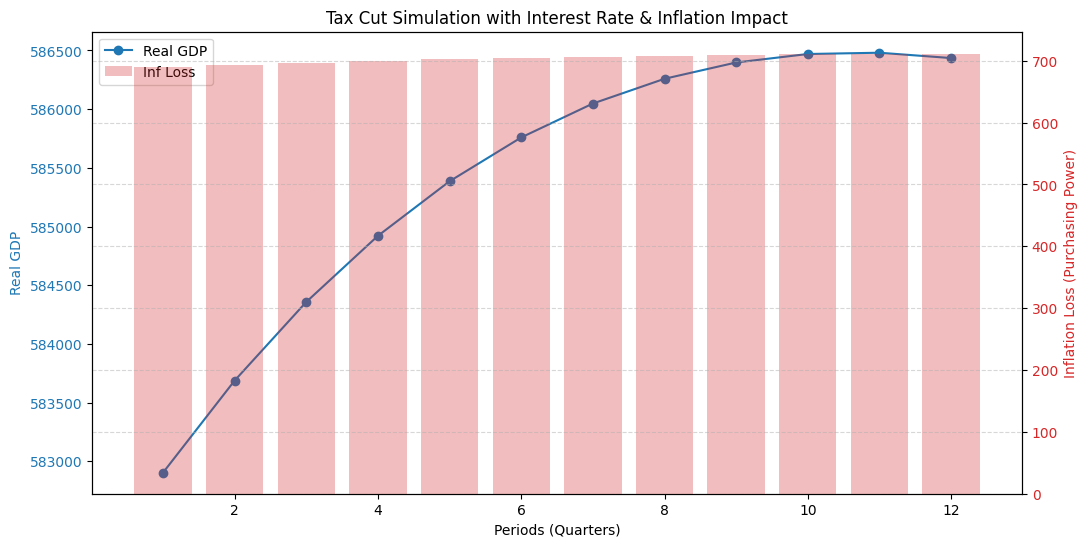

In [118]:
df_res = advanced_macro_sim(-100, 100)

# --- 図示（ご要望のイメージ） ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 左軸：実質GDP
ax1.set_xlabel('Periods (Quarters)')
ax1.set_ylabel('Real GDP', color='tab:blue')
ax1.plot(df_res['Period'], df_res['Real_GDP'], color='tab:blue', marker='o', label='Real GDP')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 右軸：インフレ損失
ax2 = ax1.twinx()
ax2.set_ylabel('Inflation Loss (Purchasing Power)', color='tab:red')
ax2.bar(df_res['Period'], df_res['Inflation_Loss'], alpha=0.3, color='tab:red', label='Inf Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 凡例の統合
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Tax Cut Simulation with Interest Rate & Inflation Impact')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

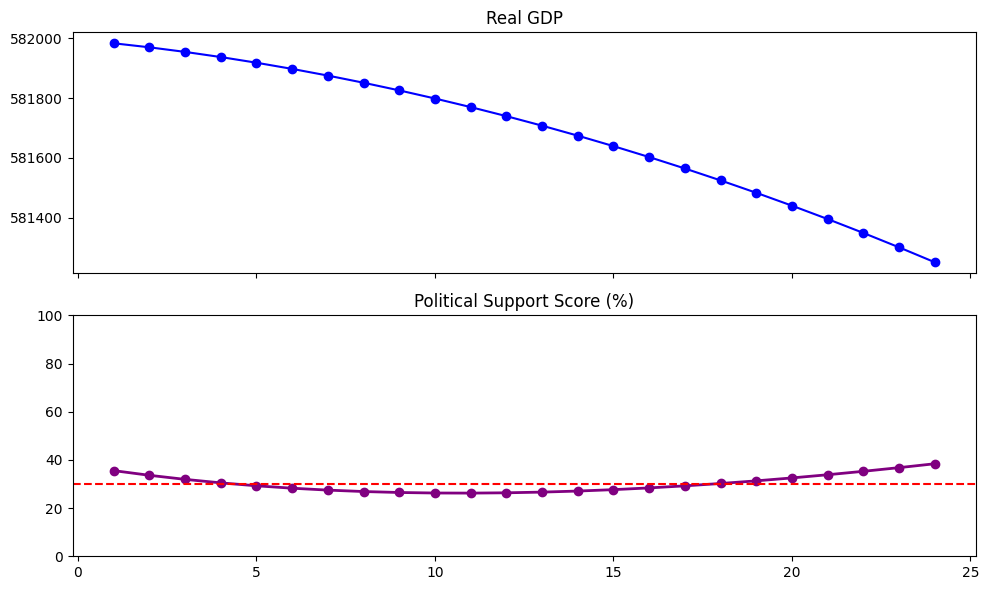

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def advanced_political_sim(t_pct=-10, short_rate_val=0.227, periods=24, 
                           w1=10, w2=15.0, w3=50.0, 
                           target_dispo = -0.5, target_pi=0.1): # target_dispoを追加
    # --- パラメータ（2SLS推定値） ---
    c0, c1, c2 = 9398.9, 0.0216, 0.9331
    i0, i1, i2 = 5875.2, 24.170, 0.9508
    p0, p1, p2 = -0.7073, 1.0033, 8.149e-07
    g0, g1, g2 = 2115.1, 0.0247, 0.9761
    r0, r1 = 1.2057, 0.4924

    # --- 初期値 ---
    def_lag = 109.9
    c_lag, i_lag, g_lag = 304995.1, 127737.0, 149262.8
    y_real_init = c_lag + i_lag + g_lag
    nominal_inc = y_real_init * (def_lag / 100)
    T_base = 69797.2
    T = T_base * (1 + t_pct / 100)
    
    # 伸び率計算用の初期可処分所得
    dispo_lag = (nominal_inc - T_base) / (def_lag / 100)
    
    support_score = 50.0  # 初期支持率
    results = []

    # --- メインループ ---
    for p in range(1, periods + 1):
        y_guess = y_real_init
        
        # 1. 経済収束計算
        for _ in range(50):
            long_rate = r0 + r1 * short_rate_val
            def_now = p0 + p1 * def_lag + p2 * y_guess
            # 実質可処分所得の計算
            real_dispo = (nominal_inc - T) / (def_now / 100)
            
            ct = c0 + c1 * real_dispo + c2 * c_lag
            it = i0 + i1 * long_rate + i2 * i_lag
            gt = g0 + g1 * T + g2 * g_lag
            y_new = ct + it + gt
            if abs(y_new - y_guess) < 0.01: break
            y_guess = y_new

        # 2. 指標（伸び率）の計算
        c_growth = (ct - c_lag) / c_lag * 100
        i_growth = (it - i_lag) / i_lag * 100
        inf_rate = (def_now - def_lag) / def_lag * 100
        # 可処分所得の伸び率を定義 (NameErrorの解消)
        dispo_growth = (real_dispo - dispo_lag) / dispo_lag * 100
        
        # --- 3. 政権体力の計算 (可処分所得ベース) ---
        gain_dispo = (dispo_growth - target_dispo) * w1
        gain_i = (i_growth * w2)
        loss_pi = (inf_rate - target_pi) * w3 if inf_rate > target_pi else 0
        
        support_score = np.clip(support_score + gain_dispo + gain_i - loss_pi, 0, 100)

        # 4. 結果格納
        results.append({
            'Period': p, 'Real_GDP': y_new, 
            'Dispo_Growth': dispo_growth, 'I_Growth': i_growth, 
            'Inflation': inf_rate, 'Support': support_score
        })
        
        # 5. ラグ更新
        c_lag, i_lag, g_lag, def_lag, y_real_init, dispo_lag = ct, it, gt, def_now, y_new, real_dispo

    return pd.DataFrame(results)

# --- 実行 ---
# 税変更なし(t_pct=0), 金利低下(short_rate_val=-10 ※極端な例), インフレ不満度9
df_final = advanced_political_sim(t_pct = 10, short_rate_val=-10, w3=9)

# --- グラフ作成 ---
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(df_final['Period'], df_final['Real_GDP'], color='blue', marker='o')
axes[0].set_title('Real GDP')

axes[1].plot(df_final['Period'], df_final['Support'], color='purple', lw=2, marker='o')
axes[1].set_ylim(0, 100)
axes[1].set_title('Political Support Score (%)')
axes[1].axhline(30, color='red', linestyle='--') # 危険水域

plt.tight_layout()
plt.show()

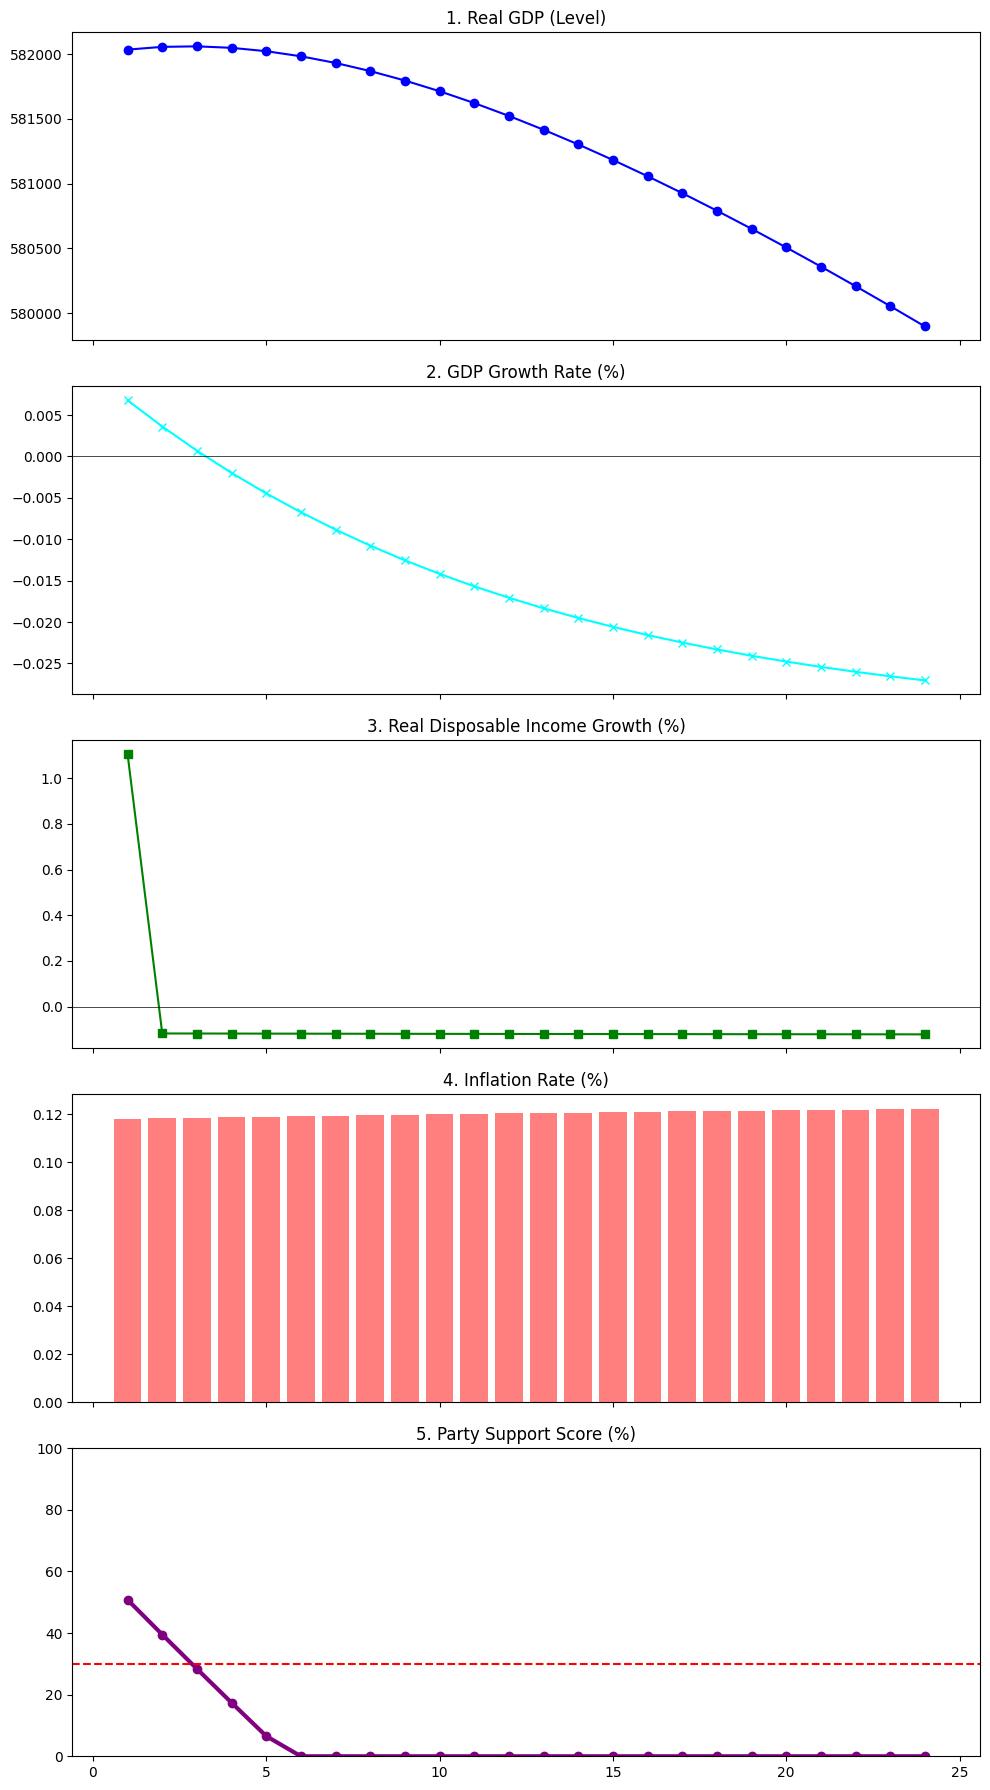

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def game_political_sim(t_pct=-10, short_rate_val=0.227, periods=24, 
                        w1=10.0, w2=15.0, w3=50.0, w4=10.0): # GDP成長率w4を追加
    # --- 2SLS推定パラメータ ---
    c0, c1, c2 = 9398.9, 0.0216, 0.9331
    i0, i1, i2 = 5875.2, 24.170, 0.9508
    p0, p1, p2 = -0.7073, 1.0033, 8.149e-07
    g0, g1, g2 = 2115.1, 0.0247, 0.9761
    r0, r1 = 1.2057, 0.4924

    # --- 初期値 ---
    def_lag = 109.9
    c_lag, i_lag, g_lag = 304995.1, 127737.0, 149262.8
    y_real_init = c_lag + i_lag + g_lag
    nominal_inc = y_real_init * (def_lag / 100)
    T_base = 69797.2
    dispo_lag = (nominal_inc - T_base) / (def_lag / 100)
    
    support_score = 50.0
    results = []

    for p in range(1, periods + 1):
        T = T_base * (1 + t_pct / 100)
        y_guess = y_real_init
        
        for _ in range(50):
            long_rate = r0 + r1 * short_rate_val
            def_now = p0 + p1 * def_lag + p2 * y_guess
            real_dispo = (nominal_inc - T) / (def_now / 100)
            ct = c0 + c1 * real_dispo + c2 * c_lag
            it = i0 + i1 * long_rate + i2 * i_lag
            gt = g0 + g1 * T + g2 * g_lag
            y_new = ct + it + gt
            if abs(y_new - y_guess) < 0.01: break
            y_guess = y_new

        # --- 成長率の計算 ---
        dispo_growth = (real_dispo - dispo_lag) / dispo_lag * 100
        i_growth = (it - i_lag) / i_lag * 100
        inf_rate = (def_now - def_lag) / def_lag * 100
        gdp_growth = (y_new - y_real_init) / y_real_init * 100 # GDP成長率

        # --- スコア計算 (w1~w4) ---
        # ターゲット（期待値）を0と仮定
        gain_dispo = dispo_growth * w1
        gain_i = i_growth * w2
        gain_gdp = gdp_growth * w4
        loss_pi = inf_rate * w3 # インフレは問答無用で失点
        
        support_score = np.clip(support_score + gain_dispo + gain_i + gain_gdp - loss_pi, 0, 100)

        results.append({
            'Period': p, 'Real_GDP': y_new, 'GDP_Growth': gdp_growth,
            'Dispo_Growth': dispo_growth, 'I_Growth': i_growth, 
            'Inflation': inf_rate, 'Support': support_score
        })
        
        # ラグ更新
        c_lag, i_lag, g_lag, def_lag, y_real_init, dispo_lag = ct, it, gt, def_now, y_new, real_dispo

    return pd.DataFrame(results)

# 実行：10%減税、短期金利は現状維持
df_game = game_political_sim(t_pct=-10)

# --- 図示（GDP成長率を加えた5枚構成） ---
fig, axes = plt.subplots(5, 1, figsize=(10, 18), sharex=True)

# 1. GDP
axes[0].plot(df_game['Period'], df_game['Real_GDP'], color='blue', marker='o')
axes[0].set_title('1. Real GDP (Level)')

# 2. GDP Growth Rate (NEW!)
axes[1].plot(df_game['Period'], df_game['GDP_Growth'], color='cyan', marker='x')
axes[1].axhline(0, color='black', lw=0.5)
axes[1].set_title('2. GDP Growth Rate (%)')

# 3. Disposable Income Growth
axes[2].plot(df_game['Period'], df_game['Dispo_Growth'], color='green', marker='s')
axes[2].axhline(0, color='black', lw=0.5)
axes[2].set_title('3. Real Disposable Income Growth (%)')

# 4. Inflation Rate (w3=50のプレッシャー)
axes[3].bar(df_game['Period'], df_game['Inflation'], color='red', alpha=0.5)
axes[3].set_title('4. Inflation Rate (%)')

# 5. Political Support Score (支持率)
axes[4].plot(df_game['Period'], df_game['Support'], color='purple', lw=3, marker='o')
axes[4].set_ylim(0, 100)
axes[4].axhline(30, color='red', linestyle='--', label='Game Over Line')
axes[4].set_title('5. Party Support Score (%)')

plt.tight_layout()
plt.show()

## なぜループするのか

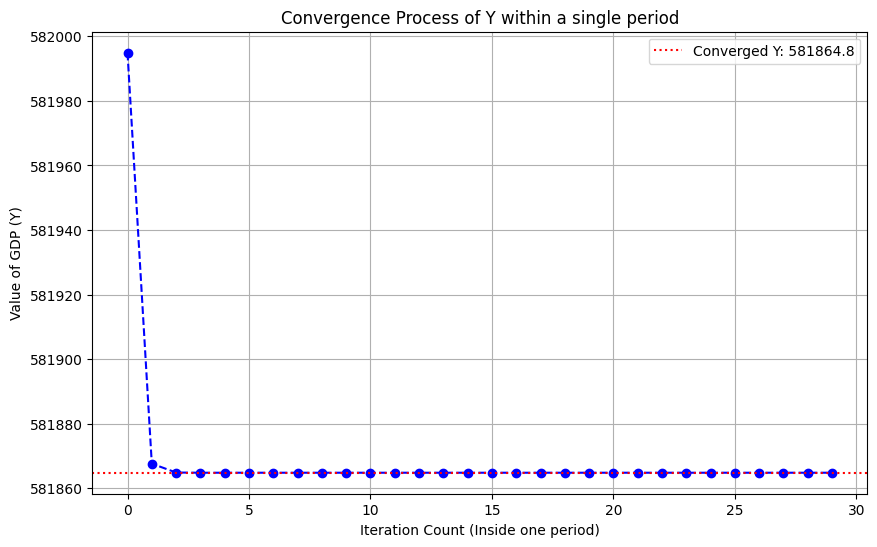

In [159]:
import matplotlib.pyplot as plt

# --- 固定された値 (t=1 の計算に必要な前提条件) ---
Ct_1 = 304995.1
It_1 = 127737.0
Gt_1 = 149262.8
T = 69797.2
r = -1.975

# 収束プロセスの記録用
y_history = []

# 1. 最初のテキトーな予測値 (前期と同じと仮定)
Y_guess = Ct_1 + It_1 + Gt_1

# 2. 収束ループ（30回繰り返して様子を見る）
for i in range(30):
    y_history.append(Y_guess)
    
    # 今の Y_guess を使って各項目を計算
    Ct = 9398.9 + 0.0216 * (Y_guess - T) + 0.9331 * Ct_1
    It = 5875.2 + 24.170 * r + 0.9508 * It_1
    Gt = 2115.1 + 0.0247 * T + 0.9761 * Gt_1
    
    # 恒等式で新しい Y を算出
    Y_new = Ct + It + Gt
    
    # 次のループのために更新
    Y_guess = Y_new

# --- 可視化 ---
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_history)), y_history, marker='o', color='b', linestyle='--')
plt.axhline(y=y_history[-1], color='r', linestyle=':', label=f"Converged Y: {y_history[-1]:.1f}")
plt.title("Convergence Process of Y within a single period")
plt.xlabel("Iteration Count (Inside one period)")
plt.ylabel("Value of GDP (Y)")
plt.grid(True)
plt.legend()
plt.show()